# VAD

In [1]:
# Este comando \\\"limpia\\\" todas las variables definidas (equivalente a clear all de Matlab)
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro de la misma Notebook, no en una ventana
%matplotlib inline

import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import numpy as np
import glob
import pyart
import pandas
import scipy
import csv
import LowPassFilter
import RadarBeamPropagation
#import radarfun


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Leemos los datos



In [3]:
path_user = '../../../../Radar/VAD/PARANA/20160114/240/'
#path_user = 'Test/'

#FileList = np.sort(glob.glob(path_user+'*.nc'))
FileList = np.sort(glob.glob(path_user + 'cfrad.20160114_060005.000_to_20160114_060431.001_INTA_Parana_SUR.nc'))
file2read=FileList[0]
print(file2read)

# Creamos el objeto "radar"
radar = pyart.io.read(file2read)

../../../../Radar/VAD/PARANA/20160114/240/cfrad.20160114_060005.000_to_20160114_060431.001_INTA_Parana_SUR.nc


/home/pao/anaconda2/lib/python2.7/site-packages/pyart/io/cfradial.py:371: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/home/pao/anaconda2/lib/python2.7/site-packages/pyart/io/cfradial.py:371: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


In [3]:
# Variables en el objeto radar
print(radar.info())
#print(radar.metadata['start_datetime'])

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	units: meters
	long_name: altitude
	positive: up
	_FillValue: -9999.0
altitude_agl:
	data: <ndarray of type: float64 and shape: (1,)>
	units: meters
	long_name: altitude_above_ground_level
	positive: up
	_FillValue: -9999.0
antenna_transition:
	data: <ndarray of type: int8 and shape: (4323,)>
	units: 
	long_name: antenna_is_in_transition_between_sweeps
	comment: 1 if antenna is in transition, 0 otherwise
	_FillValue: -128
azimuth:
	data: <ndarray of type: float32 and shape: (4323,)>
	units: degrees
	long_name: ray_azimuth_angle
	_FillValue: -9999.0
elevation:
	data: <ndarray of type: float32 and shape: (4323,)>
	units: degrees
	long_name: ray_elevation_angle
	positive: up
	_FillValue: -9999.0
fields:
	Vda:
		data: <ndarray of type: float32 and shape: (4323, 480)>
		standard_name: radial_velocity_of_scatterers_away_from_instrument
		coordinates: time range
		long_name: radial_velocity_from_horizontal_polarization
		valid_min: 

Veamos cuantos ángulos de elevaciones tenemos

In [15]:
# Angulos de elevación
elev_ang = np.unique(radar.elevation['data'])
print(elev_ang)

[  0.5          0.89999998   1.29999995   1.89999998   2.29999995   3.
   3.5          5.           6.9000001    9.10000038  11.80000019
  15.10000038]


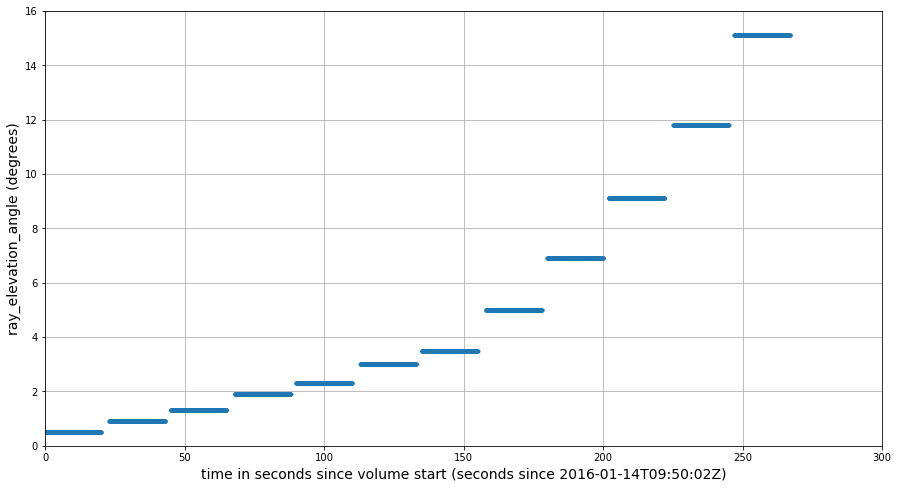

In [18]:
f = plt.figure(figsize=[15,8])

plt.plot(radar.time['data'], radar.elevation['data'] , '.')

plt.xlabel(radar.time['long_name'] + ' (' + radar.time['units'] + ')',fontsize=14)
plt.ylabel(radar.elevation['long_name'] + ' (' + radar.elevation['units'] + ')',fontsize=14)

plt.xlim([0, 300]) # En segundos
plt.ylim([0, 16])  # En grados

plt.grid()

plt.show()

In [12]:
#Fijo el ángulo de elevación
nelev=6
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

rango   = radar.range['data']
tiempo  = radar.time['data'][start_index:end_index]
azimuth = radar.azimuth['data'][start_index:end_index]
Vda     = radar.fields['Vda']['data'][start_index:end_index, :]
start_index


2163

## Gráfico PPI

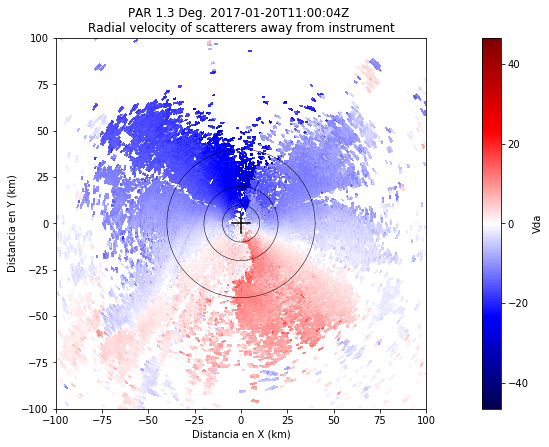

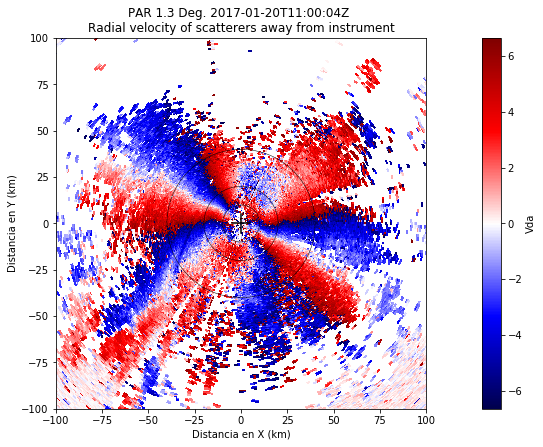

In [4]:
display = pyart.graph.RadarDisplay(radar)

xlabel = 'Distancia en X (km)'
ylabel = 'Distancia en Y (km)'

fig = plt.figure(figsize=[20,15])

ax = fig.add_subplot(211,aspect=1.0)

display.plot_ppi('Vda', sweep=2, 
                 axislabels=(xlabel,ylabel),
                 cmap='seismic',
                 #vmin=-20, vmax=20,
                 colorbar_label='Vda')

display.plot_range_rings([240],lw=1.0,col='k',ls='-')
display.plot_range_rings([10,20,40],lw=0.5,col='k',ls='-')

display.plot_cross_hair(5.)

display.set_limits(xlim=(-100, 100), ylim=(-100, 100))


fig = plt.figure(figsize=[20,15])

ax = fig.add_subplot(212,aspect=1.0)

display.plot_ppi('V', sweep=2, 
                 axislabels=(xlabel,ylabel),
                 cmap='seismic',
                 #vmin=-20, vmax=20,
                 colorbar_label='Vda')

display.plot_range_rings([240],lw=1.0,col='k',ls='-')
display.plot_range_rings([10,20,40],lw=0.5,col='k',ls='-')

display.plot_cross_hair(5.)

display.set_limits(xlim=(-100, 100), ylim=(-100, 100))

#plt.tight_layout()

plt.show()

#Azul: hacía el radar
#Rojo: desde el radar

## Calculamos la propagación del haz del radar

In [3]:
#Función que calcula la propagación de un haz según la aproximación 4R/3
## Este dato es usado luego en el algoritmo, tal vez sea mejor guardarlo aparte y llamar a la función cuando sea necesario

def propagation(r, tita, plot = 'False'):
    R = 6371.0 #km
    Rp = 4*R/3
    ht  = np.zeros(shape=(len(r),len(tita)))
    rh  = np.zeros(shape=(len(r),len(tita)))

    for i in range(len(tita)):
        for j in range(len(r)):
            temp = np.sqrt(np.power(r[j], 2)+np.power(Rp, 2)+2*r[j]*Rp*np.sin(np.pi*tita[i]/180))-Rp
            ht[j,i] = temp
            temp = r[j]*np.cos(np.pi*tita[i]/180)
            rh[j,i] = temp
    
    if plot == 'True':

        # Grafico la propagación de los rayos
        f = plt.figure(figsize = [15,10])
        plt.plot(r,ht,'-b', label='rango')
        plt.plot(rh,ht,'-r', label='rango horizontal')
        plt.xlabel('Distancia al radar [km]',fontsize='16')
        plt.ylabel('Altura [km]',fontsize='16')
        plt.legend(loc='lower right')
        plt.xlim([0, 250])
        plt.ylim([0, 14])
        plt.xticks(np.arange(0, 260, 10.0),fontsize='11')
        plt.yticks(np.arange(0, 16, 1.0),fontsize='11')
        plt.grid()
        plt.show()
    return r, ht, rh
    

r        = (radar.range['data'])/1000 #En km
elev_ang = np.unique(radar.elevation['data'])
[r, ht, rh]  = RadarBeamPropagation.propagation(r, elev_ang, plot = 'False')

    

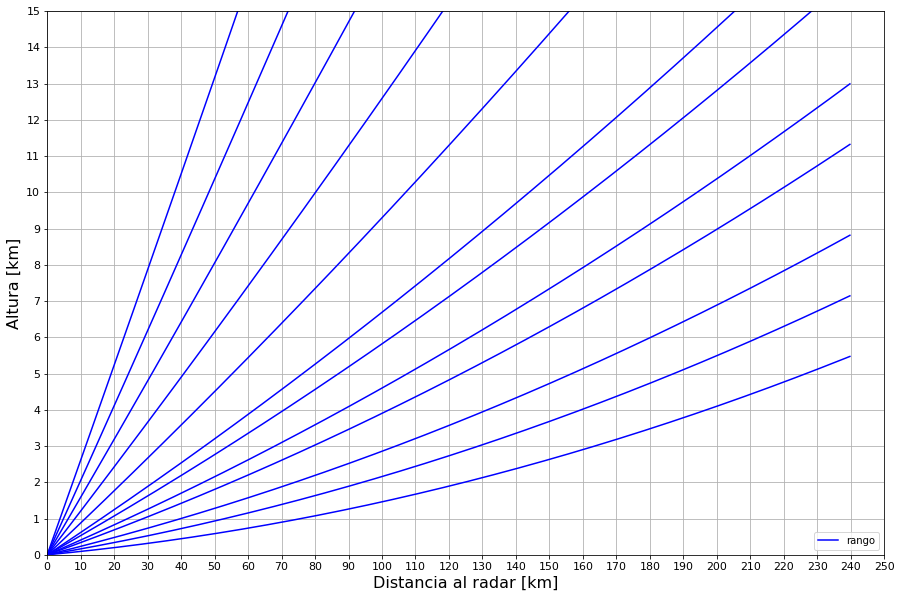

In [5]:
r        = (radar.range['data'])/1000 #En km
elev_ang = np.unique(radar.elevation['data'])
[r, ht, rh, lea]  = RadarBeamPropagation.propagation(r, elev_ang, plot = 'False')

# Grafico la propagación de los rayos
f = plt.figure(figsize = [15,10])
plt.plot(r,ht,'-b', label='rango')
plt.xlabel('Distancia al radar [km]',fontsize='16')
plt.ylabel('Altura [km]',fontsize='16')
plt.legend(loc='lower right')
plt.xlim([0, 250])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 260, 10.0),fontsize='11')
plt.yticks(np.arange(0, 16, 1.0),fontsize='11')
plt.grid()
plt.show()

## Empezamos con el cálculo

In [6]:
# Parametros

field  = 'Vda'      #Nombre de la variable en el archivo de datos
angmin = 2        #Ángulo de elevación mínimo expresado como indice y empezando en 0
angmax = 10        #Ángulo de elevación máximo expresado como indice
rint   = 0.5      #Radio interior de la arandala a calcular en Km
rext   = 40.0     #Radio exterior de la arandela a calcular
maxgap = 30       #Máximo gap sin datos permitido, en grados
maxNaN = 72      #Cantidad de de datos faltantes en un anillo
lpf    = 'False'  #Usa o no filtro pasa bajo
N      = 12       #Cantidad de datos a usar en el filtro, tiene que ser par!


# Algunas variables que necesito
nelev     = np.arange(angmin, angmax, 1) 
elev_ang  = np.unique(radar.elevation['data'])
rings     = np.zeros(shape=(len(elev_ang),2))
rings[:,1] = elev_ang
rango = radar.range['data']
r        = (radar.range['data'])/1000 #En km
DateTime = radar.metadata['start_datetime']
NameRadar= radar.metadata['site_name']

#Inicializo los arrays que van a guardar las variables spd, di, SEspd, SEdi con NaNs
spd   = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
di    = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEspd = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
spd_up = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
spd_dw = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
di_up = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
di_dw = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
var   = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
rmse  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
elev  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
a  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
b  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan

#Calculo la propagación del haz
[r, ht, rh, lea]  = RadarBeamPropagation.propagation(r, elev_ang, plot = 'False')

#Fijo el ángulo de elevación
for j in nelev:
    start_index = radar.sweep_start_ray_index['data'][j]
    end_index   = radar.sweep_end_ray_index['data'][j]

    tiempo  = radar.time['data'][start_index:end_index]
    azimuth = radar.azimuth['data'][start_index:end_index]
    Vda_raw = pandas.DataFrame(radar.fields[field]['data'][start_index:end_index], index=azimuth, columns=rango)
    cos_phi = np.cos((azimuth*np.pi)/180)
    sin_phi = np.sin((azimuth*np.pi)/180)
    elev    = elev_ang[j]
    countrings = 0
    

    for i in range(len(rango)): #Revisa cada gate

        #Subset para hacer VAD en una arandela de radio interior = rint y exterior = rext
        if (rh[i,j] < rint) | (rh[i,j] > rext):
            continue
        
        # Control de calidad de los datos 
        ## Errores aleatorios => Filtro pasa bajo

        if lpf == 'True':

            temp_Vda = np.array(Vda_raw.iloc[:,i]) #Tomo los datos de un anillo o  gate
            Vda = LowPassFilter.lowpassfl(temp_Vda, N) #Pasa por el filtro si corresponde

        else:
            Vda = Vda_raw.iloc[:,i] #Si no pasa por el filtro, solo extraigo la información para el modelo

        #Lo convierto a un DataFrame porque ols usa este tipo de formato
        temp    = pandas.DataFrame({'Vda':Vda, 'cosphi':cos_phi, 'sinphi':sin_phi})

        ## Cantidad de datos por anillo

        if temp.isnull().sum().Vda > maxNaN:
            #print 'muchos NaNs en anillo %s' % (i) 
            continue

        ## Gaps en cada anillo

        countNaN = 0
        for k in range(len(Vda)):
            if Vda_raw.isnull().iloc[k,i]:
                countNaN = countNaN + 1
                if countNaN == maxgap:
                    #print 'gap muy grande en anillo %s' % (i) 
                    continue
            else: countNaN = 0
        #print 'anillo %s válido' % (i)   
        countobs = 360 - temp.isnull().sum().Vda

        # Ahora ajusto los datos a Vr = a0 + a1cos phi + b1 sin phi

        mod     = ols('Vda ~ cos_phi + sin_phi', temp).fit()
        
        countrings = countrings + 1
        #print(mod.summary())

        ## Extraigo los coeficientes y sus errores estandar
        a0      = mod.params.Intercept
        a1      = mod.params.cos_phi
        b1      = mod.params.sin_phi
        Vda_mod = a0 + a1*cos_phi + b1*sin_phi
        a[i,j] = a1
        b[i,j] = b1
        
        ## Varianza según RadxEvad
        var[i,j]= (np.sum(np.power(temp.Vda-Vda_mod,2)))/(countobs-3)
        rmse[i,j]= np.sqrt(var[i,j])
        SEa1    = mod.bse.cos_phi
        SEb1    = mod.bse.sin_phi
        #MSEt     = mod.mse_model
        #RMSEt    = np.sqrt(MSEt)
        #u0      = b1/np.sin((elev*np.pi)/180)
        #v0      = a1/np.cos((elev*np.pi)/180)

        # Calculo el módulo y dirección del viento
        ## spd sale de Browning_and_Wexler pero no logro lograr la igualdad con el modulo, so...
        spd[i,j]    = np.sqrt(np.power(a1,2) + np.power(b1,2))/np.cos((elev*np.pi)/180) 
        #spd     = np.sqrt(np.power(u0,2) + np.power(v0,2))

        if b1 < 0:
            di[i,j] = (np.pi/2 - np.arctan(a1/b1))*180/np.pi #Lo paso a grados
            di_up[i,j] = (np.pi/2 - np.arctan((a1+SEa1)/(b1+SEb1)))*180/np.pi
            di_dw[i,j] = (np.pi/2 - np.arctan((a1-SEa1)/(b1-SEb1)))*180/np.pi
        else:
            di[i,j] = (3*np.pi/2 - np.arctan(a1/b1))*180/np.pi
            di_up[i,j] = (3*np.pi/2 - np.arctan((a1+SEa1)/(b1+SEb1)))*180/np.pi
            di_dw[i,j] = (3*np.pi/2 - np.arctan((a1-SEa1)/(b1-SEb1)))*180/np.pi

        # Calculos el error estandar para cada variable

        #SEspd[i,0]  = (abs(a1)*SEa1 + abs(b1)*SEb1)/np.sqrt(np.power(a1,2) + np.power(b1,2))*np.cos((elev*np.pi)/180) 
        #SEdi[i,0]   = (abs(a1)*SEb1 + abs(b1)*SEa1)/np.sqrt(np.power(a1,2) + np.power(b1,2))
        #Error: calculado como 2*SE de cada parámetro, cual intervalo de confianza
        #spd_up[i,j]  = np.sqrt(np.power((a1+2*SEa1),2) + np.power((b1+2*SEb1),2))/np.cos((elev*np.pi)/180) 
        #spd_dw[i,j]  = np.sqrt(np.power((a1-2*SEa1),2) + np.power((b1-2*SEb1),2))/np.cos((elev*np.pi)/180) 
        #MSE[i,j]    = MSEt
        #RMSE[i,j]   = np.sqrt(MSEt)
    rings[j,0] = countrings
    #print countrings
    
# Guardo todo en un data frame bonito
spd = spd.flatten('F')
rmse = rmse.flatten('F')
di = di.flatten('F')
rh = rh.flatten('F')
ht = ht.flatten('F')
e = np.repeat(elev_ang, len(rango), axis=0)
elev = e.reshape([len(elev_ang), len(rango)]).transpose()
elev = elev.flatten('F')
a = a.flatten('F')
b = b.flatten('F')
vad = pandas.DataFrame({'spd':spd, 'rmse':rmse, 'di':di, 'rh':rh, 'ht':ht, 'elev':elev, 'a':a, 'b':b})

vad.to_csv('Test/elev_vda2-'+ DateTime + '-' + NameRadar + '.csv', sep = ';', na_rep = '-9999')
#Muestra por pantalla la cantidad de anillos válidos para cada ángulo de elevación
print rings


/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/statsmodels/base/data.py:477: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if hasattr(x, 'ix'):
/home/pao/anaconda2/lib/python2.7/site-packages/statsmodels/base/data.py:477: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based ind

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/statsmodels/base/data.py:477: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

[[  0.           0.5       ]
 [  0.           0.89999998]
 [ 78.           1.29999995]
 [ 78.           1.89999998]
 [ 68.           2.29999995]
 [ 54.           3.        ]
 [ 48.           3.5       ]
 [ 43.           5.        ]
 [ 40.           6.9000001 ]
 [ 34.           9.10000038]
 [  0.          11.80000019]
 [  0.          15.10000038]]


/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

In [6]:
elev_ang  = np.unique(radar.elevation['data'])
elev_ang

array([  0.5       ,   0.89999998,   1.29999995,   1.89999998,
         2.29999995,   3.        ,   3.5       ,   5.        ,
         6.9000001 ,   9.10000038,  11.80000019,  15.10000038], dtype=float32)

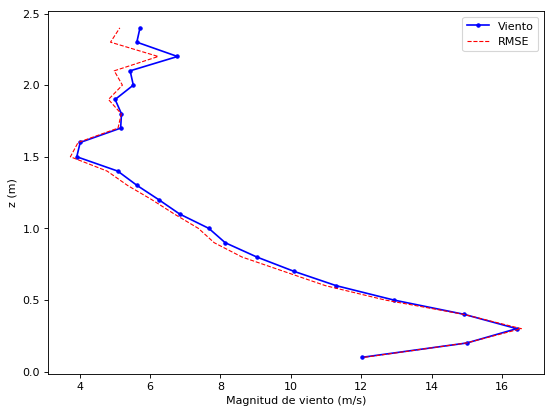

In [10]:
# Gráfico simple para evaluar los resultados cualitativamente

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
#ax.title('Viento calculado con la elevación %s grados'% nelev)
ax.plot(totalvad.spd, totalvad.ht, color='blue', marker='.', label='Viento')
ax.plot(totalvad.rmse3, totalvad.ht, color='red', linewidth=1.0, linestyle='--', label='RMSE')
ax.legend(loc='upper right')
ax.set_xlabel('Magnitud de viento (m/s)')
ax.set_ylabel('z (m)')


plt.show()


# Contruimos el perfil

In [8]:
# Vamos a contruir el perfil final del viento a partir de todos los anillos válidos según los umbrales y condiciones
# impuestas mas arriba. La idea es definir una altura mínima, una máxima y el intervalo en el que quiero los datos
# Voy a querer obtener un valor de spd, dir y el RMSE para cada nivel. La idea es hacer un promedio pesado por el 
# RMSE y la distancia al radar (rh). 

# Parámetros
minlev = 0.1  #Nivel inferior en kilometros
maxlev = 2.5  #Nivel superior en kilometros
deltalev = 0.1 #Intervalo de la grilla

# Generamos la grilla del perfil
pnlevs = ((maxlev - minlev)/deltalev)+1 #Cantidad de niveles

pht = np.zeros(shape=(int(pnlevs),))*np.nan
totalvad = pandas.DataFrame(np.zeros(shape=(int(pnlevs),7))*np.nan, columns = ['ht', 'spd', 'rmse', 'rmse2', 'rmse3', 'di', 'rings'])



for l in range(int(pnlevs)):
    
    pht[l] = minlev + l * deltalev
    upperl = pht[l] + deltalev/2
    lowerl = pht[l] - deltalev/2
    
    #Subset de los datos que se encuentran en la capa
    temp = vad.loc[(vad.ht >= lowerl) & (vad.ht < upperl) & vad.spd  & (vad.spd.notnull())]
    #Cuento la cantidad de anillos válidos en la capa
    ringpl = len(temp.spd)
    
    #Calculo el promedio de spd para la capa
    w = temp.rmse + temp.rh
    w2 = temp.rmse
    
    if not w.any():
        continue
        
    spd_wavg = np.average(np.asarray(temp.spd), weights=np.asarray(w))
    spd_wavg2 = np.average(np.asarray(temp.spd), weights=np.asarray(w2))
    di_wavg = np.average(np.asarray(temp.di), weights=np.asarray(temp.rh))
    
    #Calculo el RMSE
    var = sum(np.power(temp.spd-spd_wavg,2)/temp.rmse)/sum(1/temp.rmse)
    rmsec1 = var/np.sqrt(ringpl)
    rmsec2 = np.sqrt(1/(sum(1/np.power(temp.rmse,2))))
    #rmsec3 = sum(np.power(temp.spd-spd_wavg,2)/np.sqrt(temp.rmse))/(sum(1/np.sqrt(temp.rmse))*(ringpl-1))
    
    #Guardo en el dataframe
    totalvad.ht[l] = pht[l]
    totalvad.spd[l] = spd_wavg
    totalvad.rmse[l] = rmsec1
    totalvad.rmse2[l] = rmsec2
    totalvad.rmse3[l] = spd_wavg2
    totalvad.di[l] = di_wavg
    totalvad.rings[l] = ringpl
    
#Escribo un .csv que se guarda con la fecha y la hora del volumen de datos
totalvad.to_csv('Test/vda-'+ DateTime + '-' + NameRadar + '.csv', sep = ';', na_rep = '-9999')
print totalvad

     ht        spd      rmse     rmse2      rmse3          di  rings
0   0.1  12.027689  0.237843  0.429006  12.089901   44.143454   28.0
1   0.2  15.000563  0.199433  0.300082  14.985446   40.937739   32.0
2   0.3  16.417249  0.045833  0.254589  16.546592   38.509378   31.0
3   0.4  14.922211  0.097599  0.269071  14.906541   38.196330   32.0
4   0.5  12.919963  0.110829  0.297664  12.675283   37.451501   31.0
5   0.6  11.289462  0.147300  0.309089  10.985534   35.502914   31.0
6   0.7  10.089765  0.190478  0.334173   9.797018   34.915966   27.0
7   0.8   9.034021  0.195211  0.344282   8.612141   35.268585   31.0
8   0.9   8.134181  0.128480  0.351907   7.821712   35.693610   32.0
9   1.0   7.670054  0.126392  0.415985   7.372792   35.198864   23.0
10  1.1   6.841815  0.075150  0.447582   6.689901   32.798863   24.0
11  1.2   6.248926  0.114727  0.490932   6.051694   32.887823   22.0
12  1.3   5.628918  0.171646  0.478111   5.359348   35.716715   20.0
13  1.4   5.080898  0.174098  0.49

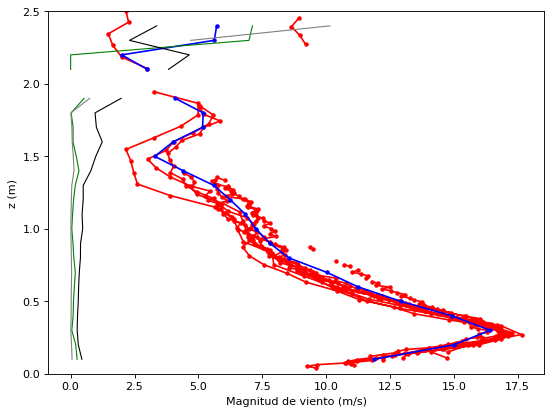

In [42]:
# Gráfico simple para evaluar los resultados cualitativamente

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
#ax.title('Viento calculado con la elevación %s grados'% nelev)
ax.plot(vad.spd,vad.ht, color='red', marker='.', label='Viento')
ax.plot(totalvad.spd, totalvad.ht, color='blue', marker='.', label='Viento')
ax.plot(totalvad.rmse, totalvad.ht, color='green', linewidth=1.0, linestyle='-', label='RMSE') #nuevo
ax.plot(totalvad.rmse2, totalvad.ht, color='black', linewidth=1.0, linestyle='-', label='RMSE')
ax.plot(totalvad.rmse3, totalvad.ht, color='grey', linewidth=1.0, linestyle='-', label='RMSE') #Wiki 2
plt.ylim([0, maxlev])
ax.set_xlabel('Magnitud de viento (m/s)')
ax.set_ylabel('z (m)')


plt.show()


# Análisis visual de los datos

In [10]:
# Es el mismo algoritmo que antes pero sin calcular el modelo, solo hace el control de los datos para ver que 
# es lo que queda.

## Parametros
rint   = 2.0      #Radio interior de la arandala a calcular en Km
rext   = 40.0     #Radio exterior de la arandela a calcular
maxgap = 30
maxNaN = 90
lpf    = 'True'
N      = 12 #Tiene que ser par!

##Subset de los datos para quedarnos con un solo ángulo de elevación

#Fijo el ángulo de elevación
nelev = 2
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]
elev_ang  = np.unique(radar.elevation['data'])
rango   = radar.range['data']
tiempo  = radar.time['data'][start_index:end_index]
azimuth = radar.azimuth['data'][start_index:end_index]
Vda_raw = pandas.DataFrame(radar.fields['Vda']['data'][start_index:end_index])
elev    = elev_ang[nelev]
countrings = 0

#Calculo la propagación del haz
r        = (radar.range['data'])/1000 #En km
[r, ht, rh]  = RadarBeamPropagation.propagation(r, elev_ang, plot = 'False')

for i in range(0,479): #Revisa cada gate
    if (rh[i,nelev] < rint) | (rh[i,nelev] > rext):
        Vda_raw.iloc[:,i] = np.repeat(np.nan, len(Vda_raw))
        continue
    
    ##Control de calidad de los datos 
    # Errores aleatorios => Filtro pasa bajo
    valido = 1
    
    if lpf == 'True':
        
        temp_Vda = np.array(Vda_raw.iloc[:,i])
        Vda_raw.iloc[:,i] = LowPassFilter.lowpassfl(temp_Vda, N)
        Vda = Vda_raw.iloc[:,i]
    else:
        Vda = Vda_raw.iloc[:,i]
        
        
    temp    = pandas.DataFrame({'Vda':Vda})

    # Cantidad de datos por anillo
    
    if temp.isnull().sum().Vda > maxNaN:
        Vda_raw.iloc[:,i] = np.repeat(np.nan, len(Vda_raw)) #Lleno de NaNs
        valido = 0
        print 'muchos NaNs en anillo %s' %(i) 
        continue
    
    # Gaps en cada anillo
    
    countNaN = 0
    for j in range(len(Vda)):
        if Vda_raw.isnull().iloc[j,i]:
            countNaN = countNaN + 1
            if countNaN == maxgap:
                Vda_raw.iloc[:,i] = np.repeat(np.nan, len(Vda_raw)) #Lleno de NaNs
                valido = 0
                print 'gap muy grande en anillo %s' %(i) 
                
            continue
        else: countNaN = 0
    
    if valido == 1:
        print 'anillo %s válido' % (i) 

Vda_cor = np.array(Vda_raw)

anillo 4 válido
anillo 5 válido
anillo 6 válido
anillo 7 válido
anillo 8 válido
anillo 9 válido
anillo 10 válido
anillo 11 válido
anillo 12 válido
anillo 13 válido
anillo 14 válido
anillo 15 válido
anillo 16 válido
anillo 17 válido
anillo 18 válido
anillo 19 válido
anillo 20 válido
anillo 21 válido
anillo 22 válido
anillo 23 válido
anillo 24 válido
anillo 25 válido
anillo 26 válido
anillo 27 válido
anillo 28 válido
anillo 29 válido
anillo 30 válido
anillo 31 válido
anillo 32 válido
anillo 33 válido
anillo 34 válido
anillo 35 válido
anillo 36 válido
anillo 37 válido
anillo 38 válido
anillo 39 válido
anillo 40 válido
anillo 41 válido
anillo 42 válido
anillo 43 válido
anillo 44 válido
anillo 45 válido
anillo 46 válido
anillo 47 válido
anillo 48 válido
anillo 49 válido
anillo 50 válido
anillo 51 válido
anillo 52 válido
anillo 53 válido
anillo 54 válido
anillo 55 válido
anillo 56 válido
anillo 57 válido
anillo 58 válido
anillo 59 válido
anillo 60 válido
anillo 61 válido
anillo 62 válido
ani

In [128]:
nelev = 0
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]
Vda_raw = pandas.DataFrame(radar.fields['Vda']['data'][start_index:end_index])
#print start_index, end_index, Vda_raw
elev_ang[0]


0.5

## Gráfico PPI del viento corregido

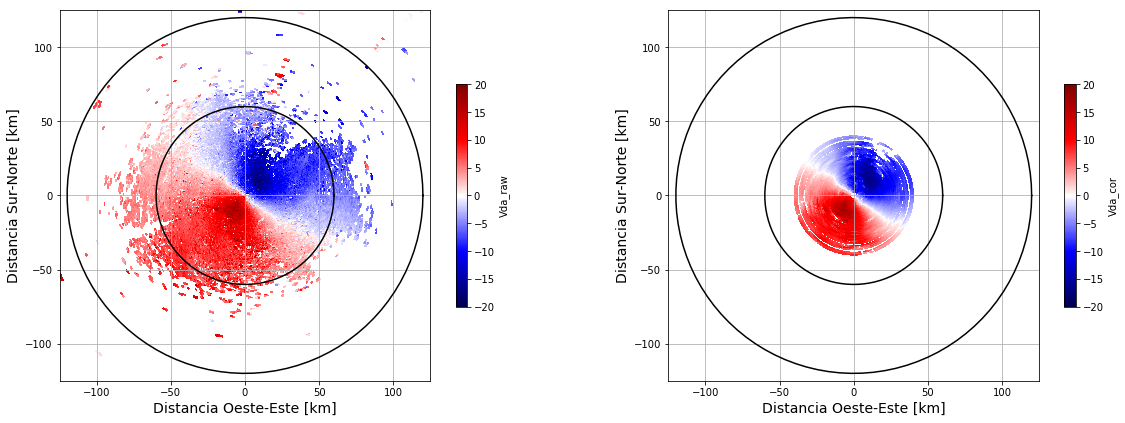

In [11]:
#Con matplotlib

Vda_raw = pandas.DataFrame(radar.fields['Vda']['data'][start_index:end_index], index=azimuth, columns=rango)
# Datos de lat/lon
lats = radar.gate_latitude['data'][start_index:end_index]
lons = radar.gate_longitude['data'][start_index:end_index]

# Datos x/y (en metros)
xdist = radar.gate_x['data'][start_index:end_index]/1000.
ydist = radar.gate_y['data'][start_index:end_index]/1000.

fig = plt.figure(figsize=[20,15])


# Graficamos Vda_raw
plt.subplot(221,aspect=1.0)
plt.pcolormesh(xdist, ydist, Vda_raw, cmap='seismic', vmin=-20, vmax=20)
plt.colorbar(shrink=0.6, label='Vda_raw')

for i in range(60,300,60):
    r = np.sqrt(i**2)
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    plt.plot(x1, x2, '-k')

plt.xlabel('Distancia Oeste-Este [km]', fontsize=14)
plt.ylabel('Distancia Sur-Norte [km]', fontsize=14)

plt.grid()

plt.xlim([-125,125])
plt.ylim([-125,125])

# Graficamos Vda_cor
plt.subplot(222,aspect=1.0)
plt.pcolormesh(xdist, ydist, Vda_cor, cmap='seismic', vmin=-20, vmax=20)
plt.colorbar(shrink=0.6, label='Vda_cor')

for i in range(60,300,60):
    r = np.sqrt(i**2)
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    plt.plot(x1, x2, '-k')

plt.xlabel('Distancia Oeste-Este [km]', fontsize=14)
plt.ylabel('Distancia Sur-Norte [km]', fontsize=14)

plt.grid()

plt.xlim([-125,125])
plt.ylim([-125,125])


plt.show()

# Abrimos un sondeo

In [83]:
filename = path_user + 'ANG/ANG/20160105/sondeos/2016010512Z.txt'
sondeo = np.loadtxt(filename)
spd = sondeo[:,7]*0.514444
ht = sondeo[:,1]-191
ht

array([     0.,    250.,    396.,    498.,    554.,    620.,    629.,
          760.,   1352.,   1432.,   1634.,   1789.,   2062.,   2288.,
         2586.,   2642.,   2962.,   3079.,   3511.,   4174.,   5309.,
         5548.,   5609.,   5952.,   6160.,   6390.,   6953.,   7279.,
         7540.,   8065.,   8290.,   8883.,   9339.,   9479.,   9790.,
        10579.,  11153.,  12019.,  12513.,  12582.,  13664.,  13829.,
        14215.,  14349.,  14395.,  14868.,  15223.,  15275.,  15538.,
        16160.,  16279.,  16339.,  16849.,  16876.,  17188.,  17473.,
        17880.,  18085.,  18499.,  18673.,  18762.,  19327.,  19387.,
        19448.,  19530.,  20224.,  20549.,  20805.,  20951.,  21496.,
        21967.,  22273.,  22789.,  23351.,  23410.,  23551.,  23759.,
        23977.,  24157.,  24203.,  24683.,  25202.,  25478.,  25856.,
        26070.,  26389.,  26728.,  26798.,  27469.,  27873.,  28304.,
        29156.,  29805.,  30397.])

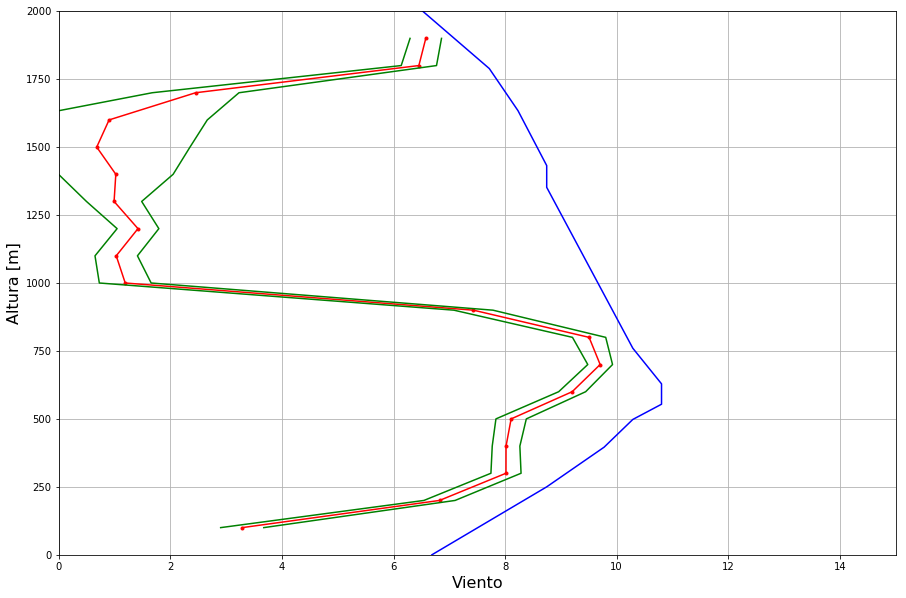

In [84]:
f = plt.figure(figsize = [15,10])
plt.plot(spd,ht,'-b')
plt.plot(totalvad.spd, totalvad.ht*1000, color='red', marker='.', label='Viento')
plt.plot(totalvad.spd+totalvad.rmse, totalvad.ht*1000, color='green', label='Viento')
plt.plot(totalvad.spd-totalvad.rmse, totalvad.ht*1000, color='green', label='Viento')
plt.xlabel('Viento',fontsize='16')
plt.ylabel('Altura [m]',fontsize='16')
plt.xlim([0, 15])
plt.ylim([0, 2000])
#plt.xticks(np.arange(0, 260, 10.0),fontsize='11')
#plt.yticks(np.arange(0, 16, 1.0),fontsize='11')
plt.grid()
plt.show()

## Análisis de consistencia temporal

In [13]:
# La idea es comparar los datos de un tiempo con tiempos anteriores antes de construir el perfil final de viento. 
# Osea, necesito abrir los archivos preliminares para algún tiempo anterior y hacer alguna prueba o promediar con
# el tiempo actual.

NameRadar = "PARANA"

# Parámetros
minlev = 0.1  #Nivel inferior en kilometros
maxlev = 2.5  #Nivel superior en kilometros
deltalev = 0.1 #Intervalo de la grilla

# Generamos la grilla del perfil
pnlevs = ((maxlev - minlev)/deltalev)+1 #Cantidad de niveles

#Inicializo el dataframe
pht = np.zeros(shape=(int(pnlevs),))*np.nan
totalvad = pandas.DataFrame(np.zeros(shape=(int(pnlevs),7))*np.nan, columns = ['ht', 'spd', 'rmse', 'rmse2', 'rmse3', 'di', 'rings'])

#Leemos los archivos
path_user = '../../20160114_240/'
FileList = np.sort(glob.glob(path_user + 'elev*'))

for f in range(len(FileList)):
    #Salteo los primeros 2 tiempos y arranco en el tercero usando los anteriores
    if ((f < 1) | (f > len(FileList) - 2)):
        vad = pandas.read_csv(FileList[f], sep=';', header=0, na_values=-9999.0)
    
    else:
        vad_now = pandas.read_csv(FileList[f], sep=';', header=0, na_values=-9999.0) # Tiempo actual
        vad_1 = pandas.read_csv(FileList[f-1], sep=';', header=0, na_values=-9999.0) # Tiempo -1
        vad_2 = pandas.read_csv(FileList[f+1], sep=';', header=0, na_values=-9999.0) # Tiempo +1

        
        vad = pandas.concat([vad_now, vad_1, vad_2])

    for l in range(int(pnlevs)):

        pht[l] = minlev + l * deltalev
        upperl = pht[l] + deltalev/2
        lowerl = pht[l] - deltalev/2

        #Subset de los datos que se encuentran en la capa
        temp = vad.loc[(vad.ht >= lowerl) & (vad.ht < upperl) & vad.spd  & (vad.spd.notnull())]
        #Cuento la cantidad de anillos válidos en la capa
        ringpl = len(temp.spd)

        #Calculo el promedio de spd para la capa
        
        w = temp.rmse + temp.rh
        if not w.any():
            continue

        spd_wavg = np.average(np.asarray(temp.spd), weights=np.asarray(w))
        di_wavg = np.average(np.asarray(temp.di), weights=np.asarray(temp.rh))

        #Calculo el RMSE
        var = sum(np.power(temp.spd-spd_wavg,2)/temp.rmse)/sum(1/temp.rmse)
        rmsec1 = var/np.sqrt(ringpl)
        rmsec2 = np.sqrt(1/(sum(1/np.power(temp.rmse,2))))
        rmsec3 = sum(np.power(temp.spd-spd_wavg,2)/np.sqrt(temp.rmse))/(sum(1/np.sqrt(temp.rmse))*(ringpl-1))

        #Guardo en el dataframe
        totalvad.ht[l] = pht[l]
        totalvad.spd[l] = spd_wavg
        totalvad.rmse[l] = rmsec1
        totalvad.rmse2[l] = rmsec2
        totalvad.rmse3[l] = rmsec3
        totalvad.di[l] = di_wavg
        totalvad.rings[l] = ringpl

    #Escribo un .csv que se guarda con la fecha y la hora del volumen de datos
    totalvad.to_csv('../../20160114_240/'+ FileList[f][24:64], sep = ';', na_rep = '-9999')
    #print totalvad

/home/pao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in double_scalars
/home/pao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in double_scalars


In [4]:
path_user = '20160114_240/'
FileList = np.sort(glob.glob(path_user + 'elev*'))
vad_now = pandas.read_csv(FileList[2], sep=';', header=0, na_values=-9999.0) # Tiempo actual
vad_1 = pandas.read_csv(FileList[1], sep=';', header=0, na_values=-9999.0) # Tiempo -1
vad_2 = pandas.read_csv(FileList[0], sep=';', header=0, na_values=-9999.0) # Tiempo -2
        
vad = pandas.concat([vad_now, vad_1, vad_2])
vad_now['tw'] = 2 
print vad_now

      Unnamed: 0   a   b  di  elev         ht          rh  rmse  rs  spd  tw
0              0 NaN NaN NaN   0.5   0.002185    0.249990   NaN NaN  NaN   2
1              1 NaN NaN NaN   0.5   0.006578    0.749971   NaN NaN  NaN   2
2              2 NaN NaN NaN   0.5   0.011000    1.249952   NaN NaN  NaN   2
3              3 NaN NaN NaN   0.5   0.015452    1.749933   NaN NaN  NaN   2
4              4 NaN NaN NaN   0.5   0.019933    2.249914   NaN NaN  NaN   2
5              5 NaN NaN NaN   0.5   0.024443    2.749895   NaN NaN  NaN   2
6              6 NaN NaN NaN   0.5   0.028983    3.249876   NaN NaN  NaN   2
7              7 NaN NaN NaN   0.5   0.033552    3.749857   NaN NaN  NaN   2
8              8 NaN NaN NaN   0.5   0.038151    4.249838   NaN NaN  NaN   2
9              9 NaN NaN NaN   0.5   0.042779    4.749819   NaN NaN  NaN   2
10            10 NaN NaN NaN   0.5   0.047437    5.249800   NaN NaN  NaN   2
11            11 NaN NaN NaN   0.5   0.052123    5.749781   NaN NaN  NaN   2